# Normalization, Annotation & Integration

# Import modules

In [1]:
import torch

torch.cuda.is_available()

True

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi

/g/data/ei56/pa3687/miniforge3/envs/ild-bal-scrna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Celltypist - predicting cell types

In [4]:
import celltypist
from celltypist import models

## Creating reference from published data

The rds object from the published study needs to be converted for use in Celltypist

In [5]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()

cffi mode is CFFI_MODE.ANY
R home found: /g/data/ei56/pa3687/miniforge3/envs/ild-bal-scrna/lib/R
R library path: 
LD_LIBRARY_PATH: 
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.


In [ ]:
robjects.r('''
library(Seurat)
library(SummarizedExperiment)

rse <- readRDS("/share/ScratchGeneral/petall/IPF_NFE2L2_AlvMac/data/bal/ref_data/BALF_CF/GSE193782_SeuratObject.rds")

seurat_object <- CreateSeuratObject(counts = rse@assays$RNA@counts, meta.data = as.data.frame(rse@meta.data))

BAL_CF <- as.SingleCellExperiment(seurat_object)
''')

In [ ]:
BAL_CF = robjects.r['BAL_CF']
BAL_CF.obs

In [ ]:
sc.pp.normalize_total(BAL_CF, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(BAL_CF)

In [ ]:
## Takes about 90 minutes
bal_cf_model = celltypist.train(BAL_CF, labels = 'Cell.Types', n_jobs = 22,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

In [ ]:
bal_cf_model.write('/home/petall/.celltypist/data/models/bal_cf.pkl')

## Load celltypist models

To preserve memory, the kernel was restarted at this point and the packages reimported.

In [6]:
bal_cf_model = models.Model.load(model="/g/data/ei56/pa3687/.celltypist/data/models/bal_cf.pkl")
hcla_v2_model = models.Model.load(model="/g/data/ei56/pa3687/.celltypist/data/models/Human_Lung_Atlas.pkl")
lung_pf_model = models.Model.load(model="/g/data/ei56/pa3687/.celltypist/data/models/Human_PF_Lung.pkl")
lung_airway_model = models.Model.load(model="/g/data/ei56/pa3687/.celltypist/data/models/Cells_Lung_Airway.pkl")


In [7]:
def predict_cells(adata):
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.normalize_total(adata, target_sum=1e4) #not recommended for typical pp
    sc.pp.log1p(adata)

    adata.X = adata.X.toarray()

    predictions = celltypist.annotate(adata, model=bal_cf_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["bal_cf_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["bal_cf_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=hcla_v2_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["hclaV2_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["hclaV2_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=lung_pf_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["lung_pf_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["lung_pf_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=lung_airway_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["lung_airway_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["lung_airway_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    return adata.obs

In [10]:
import glob
adatas = [sc.read_h5ad(x) for x in glob.glob('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/data/02-preprocessed/individual-adatas/*.h5ad')]

In [11]:
len(adatas)

9

In [12]:
predictions = [predict_cells(ad.copy()) for ad in adatas]

🔬 Input data has 13183 cells and 21134 genes
🔗 Matching reference genes in the model
🧬 2136 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 13183 cells and 21134 genes
🔗 Matching reference genes in the model
🧬 4140 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 13183 cells and 21134 genes
🔗 Matching reference genes in the model
🧬 3039 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 13183 cells and 21134 genes
🔗 Matching reference genes in the model
🧬 4222 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 15118 cells and 22306 genes
🔗 Matching reference genes in the model
🧬 2146 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 15118 cells and 22306 genes
🔗 Matching reference genes in the model


In [13]:
predictions = pd.concat(predictions)[['bal_cf_label', 'bal_cf_score', 'hclaV2_label', 'hclaV2_score', 'lung_pf_label', 'lung_pf_score', 'lung_airway_label', 'lung_airway_score']]

predictions

,bal_cf_label,bal_cf_score,hclaV2_label,hclaV2_score,lung_pf_label,lung_pf_score,lung_airway_label,lung_airway_score
new_index,,,,,,,,
AAACCCAAGAGTCAAT-1-B3_RZ725-IPF,AMs,0.981049,Alveolar macrophages,0.991815,Macrophages,0.999847,Macro_alveolar,0.993530
AAACCCAAGCTTAAGA-1-B5_RZ725-SR-ILD,Mono,0.987569,Alveolar macrophages,0.946023,Macrophages,0.998183,Macro_alveolar,0.995791
AAACCCAAGGCGAAGG-1-B6_RZ725-Silicosis,Mono,0.999173,Alveolar macrophages,0.977244,Macrophages,0.990317,Macro_alveolar,0.354005
AAACCCAAGGCGACAT-1-B2_RZ725-Silicosis,AMs,0.999996,Alveolar macrophages,0.983614,Macrophages,0.999571,Macro_alveolar,0.975494
AAACCCAAGTACAGCG-1-B6_RZ725-Silicosis,AMs,1.000000,Alveolar macrophages,0.943015,Macrophages,0.999041,Macro_alveolar,0.999951
...,...,...,...,...,...,...,...,...
TTTGTCAGTACCAGTT-1-BAL_scRNA_Sample10-Sarcoidosis,DC2,1.000000,DC2,0.998542,cDCs,0.559658,DC_2,0.999983
TTTGTCAGTTACGCGC-1-BAL_scRNA_Sample10-Sarcoidosis,AMs,0.811490,Alveolar macrophages,0.941766,Macrophages,0.992557,Macro_alveolar,0.999213
TTTGTCAGTTATCGGT-1-BAL_scRNA_Sample10-Sarcoidosis,Mono,0.569074,Alveolar macrophages,0.890885,Macrophages,0.996713,Macro_alveolar,0.998390


# Merging Adatas (pre-integration)

In [14]:
for adata_single in adatas:
    adata_single.var_names_make_unique()

adata = sc.concat(adatas)

In [15]:
predictions.to_csv('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/reports/celltypist_predictions.csv')

In [16]:
adata.obs = adata.obs.merge(right = predictions, left_index=True, right_index=True)

## Annotating using scimilarity

In [19]:
adata.obs.disease_final.value_counts()

disease_final
IPF            45222
Sarcoidosis    18810
HP              9250
NSIP            7966
SR-ILD          6295
Silicosis       4579
PPFE            1861
Name: count, dtype: int64

In [20]:
sc.pp.filter_genes(adata, min_cells = 10)

In [20]:
adata.write_h5ad('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/data/02-preprocessed/temp.h5ad')

... storing 'Barcode' as categorical
... storing 'bal_cf_label' as categorical
... storing 'hclaV2_label' as categorical
... storing 'lung_pf_label' as categorical
... storing 'lung_airway_label' as categorical


# Use Scimilarity for Cell Annotation (triple loss model)

A python script `bal_scimilarity_annotation.py` was written to be run on the unintegrated data and generate a csv file with the barcodes and predictions. Submit the job to generate  `scimilarity_annotations.csv` in the `/data` folder. 

In [5]:
print("Starting Scimilarity Annotation...")

# Import Scimilarity Modules and Model
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellAnnotation

model_path = "/g/data/ei56/pa3687/.scimilarity/model_v1.1"
ca = CellAnnotation(model_path=model_path)
print("Scimilarity model loaded...")


# Import and Normalize query adata

## Load scRNA data
data_path = '/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/data/02-preprocessed/temp.h5ad'

adata = sc.read(data_path)

## Match feature space with Scimilarity models
adata = align_dataset(adata, ca.gene_order)

## Comute Embeddings
adata.obsm["X_scimilarity"] = ca.get_embeddings(adata.X)

## Use Unconstrained Model (Anything and Everything from model)
predictions, nn_idx, nn_dists, nn_stats = ca.get_predictions_knn(
    adata.obsm["X_scimilarity"]
)

adata.obs["predictions_unconstrained"] = predictions.values
adata = ca.annotate_dataset(adata)

Starting Scimilarity Annotation...
Scimilarity model loaded...
Get nearest neighbors finished in: 0.02154362201690674 min


100%|██████████| 93983/93983 [00:29<00:00, 3205.92it/s]


Get nearest neighbors finished in: 0.020206101735432944 min


100%|██████████| 93983/93983 [00:29<00:00, 3162.62it/s]


## Constrained Model

In [6]:
target_celltypes = [
    #myeloid
    "classical monocyte",
    "non-classical monocyte",
    "alveolar macrophage",
    "macrophage",
    "plasmacytoid dendritic cell",
    "conventional dendritic cell",

    #lymphoid - B
    "B cell",
    "plasma cell",

    #lymphoid - T
    "type II pneumocyte",
    "endothelial cell of vascular tree",
    "club cell",
    "endothelial cell of lymphatic vessel",
    "CD4-positive, alpha-beta T cell",
    "CD8-positive, alpha-beta T cell",
    "mature NK T cell",
    "natural killer cell",

    #stromal
    "respiratory basal cell",
    "fibroblast",
    "myofibroblast cell",
    "basal cell",
    "ciliated cell",
    "vascular associated smooth muscle cell",

    #epithelial
    "mast cell",
    "type I pneumocyte",
    "secretory cell",
    "goblet cell",
    "pericyte",
    "neuroendocrine cell",
    "pulmonary ionocyte",
]

ca.safelist_celltypes(target_celltypes)
adata = ca.annotate_dataset(adata)


# Output results
annotations = adata.obs[['celltype_hint', 'predictions_unconstrained', 'min_dist']]

output_path = '/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/reports/scimilarity_predictions.csv'
annotations.to_csv(output_path, index=True)

print("Scimilarity Annotation...Complete!")

Get nearest neighbors finished in: 0.040105871359507245 min


100%|██████████| 93983/93983 [00:29<00:00, 3159.35it/s]


Scimilarity Annotation...Complete!


# Load Unintegrated data

In [4]:
adata = sc.read_h5ad('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/data/02-preprocessed/temp.h5ad')
adata

AnnData object with n_obs × n_vars = 93983 × 38592
    obs: 'Sample', 'Pool', 'Doublet', 'Barcode', 'disease_final', 'sex', 'age_at_sampling', 'antifibrotics', 'immunosuppression', 'telomere_length', 'smoking_0_ex1_current2', '10X_chemistry', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'bal_cf_label', 'bal_cf_score', 'hclaV2_label', 'hclaV2_score', 'lung_pf_label', 'lung_pf_score', 'lung_airway_label', 'lung_airway_score'

In [5]:
scimilarity_annotations = pd.read_csv('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/reports/scimilarity_predictions.csv', index_col=0)

scimilarity_annotations = scimilarity_annotations.rename(columns={"celltype_hint": "scim_predictions_constrained", "predictions_unconstrained": "scim_predictions_unconstrained", "min_dist": "scimilarity_distance"})

scimilarity_annotations

,scim_predictions_constrained,scim_predictions_unconstrained,scimilarity_distance
AAACCCAAGAGTCAAT-1-B3_RZ725-IPF,alveolar macrophage,alveolar macrophage,0.024374
AAACCCAAGCTTAAGA-1-B5_RZ725-SR-ILD,alveolar macrophage,alveolar macrophage,0.021422
AAACCCAAGGCGAAGG-1-B6_RZ725-Silicosis,alveolar macrophage,alveolar macrophage,0.037640
AAACCCAAGGCGACAT-1-B2_RZ725-Silicosis,alveolar macrophage,alveolar macrophage,0.022384
AAACCCAAGTACAGCG-1-B6_RZ725-Silicosis,alveolar macrophage,alveolar macrophage,0.011204
...,...,...,...
TTTGTCAGTACCAGTT-1-BAL_scRNA_Sample10-Sarcoidosis,conventional dendritic cell,conventional dendritic cell,0.044894
TTTGTCAGTTACGCGC-1-BAL_scRNA_Sample10-Sarcoidosis,alveolar macrophage,alveolar macrophage,0.049849
TTTGTCAGTTATCGGT-1-BAL_scRNA_Sample10-Sarcoidosis,alveolar macrophage,alveolar macrophage,0.040485
TTTGTCAGTTGTCTTT-1-BAL_scRNA_Sample10-Sarcoidosis,alveolar macrophage,alveolar macrophage,0.033229


In [6]:
adata.obs = adata.obs.merge(right = scimilarity_annotations, left_index=True, right_index=True)

In [7]:
adata.obs

,Sample,Pool,Doublet,Barcode,disease_final,sex,age_at_sampling,antifibrotics,immunosuppression,telomere_length,...,bal_cf_score,hclaV2_label,hclaV2_score,lung_pf_label,lung_pf_score,lung_airway_label,lung_airway_score,scim_predictions_constrained,scim_predictions_unconstrained,scimilarity_distance
AAACCCAAGAGTCAAT-1-B3_RZ725-IPF,B3_RZ725,RZ725_Pool4,singlet,AAACCCAAGAGTCAAT-1,IPF,male,66,None-butwentontoAccendatechclinicaltrialFeb2021,None-buthadshortpredFeb2021forwheeze,>10thcentile,...,0.981049,Alveolar macrophages,0.991815,Macrophages,0.999847,Macro_alveolar,0.993530,alveolar macrophage,alveolar macrophage,0.024374
AAACCCAAGCTTAAGA-1-B5_RZ725-SR-ILD,B5_RZ725,RZ725_Pool4,singlet,AAACCCAAGCTTAAGA-1,SR-ILD,male,42,None,None,>10thcentile,...,0.987569,Alveolar macrophages,0.946023,Macrophages,0.998183,Macro_alveolar,0.995791,alveolar macrophage,alveolar macrophage,0.021422
AAACCCAAGGCGAAGG-1-B6_RZ725-Silicosis,B6_RZ725,RZ725_Pool4,singlet,AAACCCAAGGCGAAGG-1,Silicosis,male,24,None,None,NA,...,0.999173,Alveolar macrophages,0.977244,Macrophages,0.990317,Macro_alveolar,0.354005,alveolar macrophage,alveolar macrophage,0.037640
AAACCCAAGGCGACAT-1-B2_RZ725-Silicosis,B2_RZ725,RZ725_Pool4,singlet,AAACCCAAGGCGACAT-1,Silicosis,male,23,None,None,NA,...,0.999996,Alveolar macrophages,0.983614,Macrophages,0.999571,Macro_alveolar,0.975494,alveolar macrophage,alveolar macrophage,0.022384
AAACCCAAGTACAGCG-1-B6_RZ725-Silicosis,B6_RZ725,RZ725_Pool4,singlet,AAACCCAAGTACAGCG-1,Silicosis,male,24,None,None,NA,...,1.000000,Alveolar macrophages,0.943015,Macrophages,0.999041,Macro_alveolar,0.999951,alveolar macrophage,alveolar macrophage,0.011204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACCAGTT-1-BAL_scRNA_Sample10-Sarcoidosis,BAL_scRNA_Sample10,BAL_scRNA_Sample10,singlet,TTTGTCAGTACCAGTT-1,Sarcoidosis,male,45,NA,NA,NA,...,1.000000,DC2,0.998542,cDCs,0.559658,DC_2,0.999983,conventional dendritic cell,conventional dendritic cell,0.044894
TTTGTCAGTTACGCGC-1-BAL_scRNA_Sample10-Sarcoidosis,BAL_scRNA_Sample10,BAL_scRNA_Sample10,singlet,TTTGTCAGTTACGCGC-1,Sarcoidosis,male,45,NA,NA,NA,...,0.811490,Alveolar macrophages,0.941766,Macrophages,0.992557,Macro_alveolar,0.999213,alveolar macrophage,alveolar macrophage,0.049849
TTTGTCAGTTATCGGT-1-BAL_scRNA_Sample10-Sarcoidosis,BAL_scRNA_Sample10,BAL_scRNA_Sample10,singlet,TTTGTCAGTTATCGGT-1,Sarcoidosis,male,45,NA,NA,NA,...,0.569074,Alveolar macrophages,0.890885,Macrophages,0.996713,Macro_alveolar,0.998390,alveolar macrophage,alveolar macrophage,0.040485
TTTGTCAGTTGTCTTT-1-BAL_scRNA_Sample10-Sarcoidosis,BAL_scRNA_Sample10,BAL_scRNA_Sample10,singlet,TTTGTCAGTTGTCTTT-1,Sarcoidosis,male,45,NA,NA,NA,...,0.998419,Alveolar macrophages,0.999149,Macrophages,0.992370,Macro_alveolar,0.998125,alveolar macrophage,alveolar macrophage,0.033229


# Normalization

## Shifted Logarithm

In [8]:
adata.layers['counts'] = adata.X.copy()
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

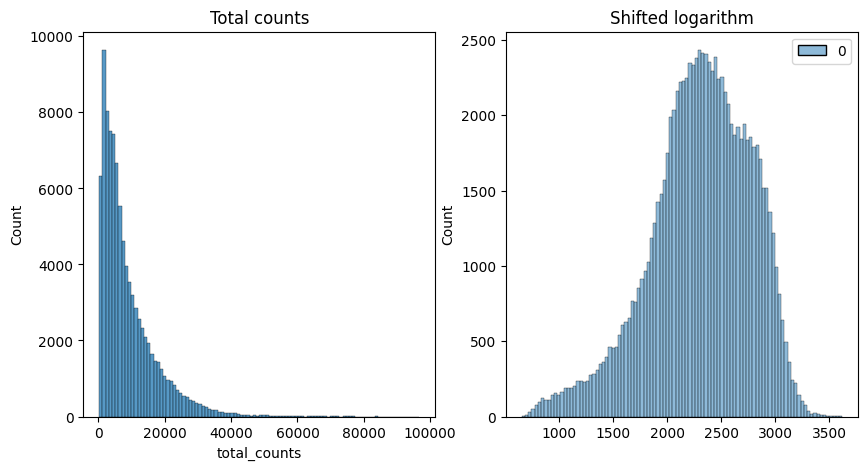

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

# Integration

## scVI

One method of integration is fine-tuning the hyperparameters through the ray-tune package. Unfortunately there are some conflicting package versions that prevent me from using it so using scVI's default parameters but setting the max-epochs to 200.

In [10]:
adata.obs.keys()

Index(['Sample', 'Pool', 'Doublet', 'Barcode', 'disease_final', 'sex',
       'age_at_sampling', 'antifibrotics', 'immunosuppression',
       'telomere_length', 'smoking_0_ex1_current2', '10X_chemistry', 'n_genes',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt',
       'pct_counts_ribo', 'pct_counts_hb', 'bal_cf_label', 'bal_cf_score',
       'hclaV2_label', 'hclaV2_score', 'lung_pf_label', 'lung_pf_score',
       'lung_airway_label', 'lung_airway_score',
       'scim_predictions_constrained', 'scim_predictions_unconstrained',
       'scimilarity_distance'],
      dtype='object')

Integrating at the Pool level as using Sample as a covariate led to overfitting.

In [11]:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                             categorical_covariate_keys=['Pool', '10X_chemistry'],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])


In [12]:
model = scvi.model.SCVI(adata)

In [13]:
model.train(max_epochs = 200, check_val_every_n_epoch=1, early_stopping = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [48:54<00:00, 14.57s/it, v_num=1, train_loss_step=7.09e+3, train_loss_epoch=7.33e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [48:54<00:00, 14.67s/it, v_num=1, train_loss_step=7.09e+3, train_loss_epoch=7.33e+3]


In [14]:
model.save('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/models/bal_pool_chemistry_scvi_model/')

In [ ]:
model = scvi.model.SCVI.load('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/models/bal_pool_chemistry_scvi_model/', adata)

In [15]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

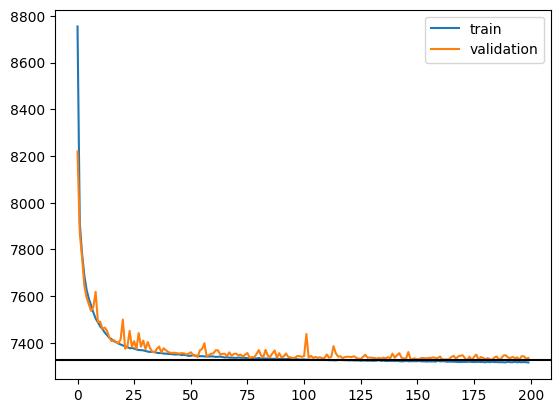

In [16]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [17]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression()

In [3]:
# Save Integrated Scanpy Object
# adata.write_h5ad('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/data/03-final/integrated.h5ad')

# Import Integrated Scanpy Object
adata = sc.read_h5ad('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/data/03-final/integrated.h5ad')

# Convert to Seurat

In [ ]:
# Convert to Seurat
